# Text classification
Classifying News-Headlines into four categories - Economy, Obama, Microsoft, Palenstine. 

##Dataset source:-

https://archive.ics.uci.edu/ml/machine-learning-databases/00432/Data/


In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
sns.set(style='whitegrid')

from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import classification_report,confusion_matrix

from collections import defaultdict
from collections import Counter

import re
import gensim
import string

from tqdm import tqdm
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM,Dense, SpatialDropout1D, Dropout
from keras.initializers import Constant

import warnings
warnings.simplefilter('ignore')
import tensorflow as tf

# Loading dataset

In [2]:
#!wget "https://github.com/profsarang/Springer/raw/main/News_Final.zip"
!wget 'https://raw.githubusercontent.com/profsarang/ThinkingDataScience/main/data/News_Final.zip'


--2022-09-12 07:57:06--  https://raw.githubusercontent.com/profsarang/ThinkingDataScience/main/data/News_Final.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10734983 (10M) [application/zip]
Saving to: ‘News_Final.zip’

News_Final.zip      100%[===================>]  10.24M  --.-KB/s    in 0.03s   

2022-09-12 07:57:07 (392 MB/s) - ‘News_Final.zip’ saved [10734983/10734983]



In [3]:
!unzip /content/News_Final.zip


Archive:  /content/News_Final.zip
  inflating: News_Final.csv          
  inflating: __MACOSX/._News_Final.csv  


In [4]:
df=pd.read_csv('/content/News_Final.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93239 entries, 0 to 93238
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   IDLink             93239 non-null  float64
 1   Title              93239 non-null  object 
 2   Headline           93224 non-null  object 
 3   Source             92960 non-null  object 
 4   Topic              93239 non-null  object 
 5   PublishDate        93239 non-null  object 
 6   SentimentTitle     93239 non-null  float64
 7   SentimentHeadline  93239 non-null  float64
 8   Facebook           93239 non-null  int64  
 9   GooglePlus         93239 non-null  int64  
 10  LinkedIn           93239 non-null  int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 7.8+ MB


In [6]:
df.head()

,IDLink,Title,Headline,Source,Topic,PublishDate,SentimentTitle,SentimentHeadline,Facebook,GooglePlus,LinkedIn
0,99248.0,Obama Lays Wreath at Arlington National Cemetery,Obama Lays Wreath at Arlington National Cemete...,USA TODAY,obama,2002-04-02 00:00:00,0.000000,-0.053300,-1,-1,-1
1,10423.0,A Look at the Health of the Chinese Economy,"Tim Haywood, investment director business-unit...",Bloomberg,economy,2008-09-20 00:00:00,0.208333,-0.156386,-1,-1,-1
2,18828.0,Nouriel Roubini: Global Economy Not Back to 2008,"Nouriel Roubini, NYU professor and chairman at...",Bloomberg,economy,2012-01-28 00:00:00,-0.425210,0.139754,-1,-1,-1
3,27788.0,Finland GDP Expands In Q4,Finland's economy expanded marginally in the t...,RTT News,economy,2015-03-01 00:06:00,0.000000,0.026064,-1,-1,-1
4,27789.0,"Tourism, govt spending buoys Thai economy in J...",Tourism and public spending continued to boost...,The Nation - Thailand&#39;s English news,economy,2015-03-01 00:11:00,0.000000,0.141084,-1,-1,-1


In [7]:
df.loc[:,['Title','Headline','Topic']]

,Title,Headline,Topic
0,Obama Lays Wreath at Arlington National Cemetery,Obama Lays Wreath at Arlington National Cemete...,obama
1,A Look at the Health of the Chinese Economy,"Tim Haywood, investment director business-unit...",economy
2,Nouriel Roubini: Global Economy Not Back to 2008,"Nouriel Roubini, NYU professor and chairman at...",economy
3,Finland GDP Expands In Q4,Finland's economy expanded marginally in the t...,economy
4,"Tourism, govt spending buoys Thai economy in J...",Tourism and public spending continued to boost...,economy
...,...,...,...
93234,Stocks rise as investors key in on US economy ...,The June employment report is viewed as a cruc...,economy
93235,Russian PM proposes to use conservative and to...,"In addition, establish stimulating economic po...",economy
93236,Palestinian Government Uses Foreign Aid To Pay...,The Palestinian government spends nearly $140 ...,palestine
93237,Palestine Youth Orchestra prepares for first U...,Palestine Youth Orchestra prepares for first U...,palestine


In [8]:
df.shape

(93239, 11)

# Data distribution

In [9]:
df.Topic.value_counts()

economy      33928
obama        28610
microsoft    21858
palestine     8843
Name: Topic, dtype: int64

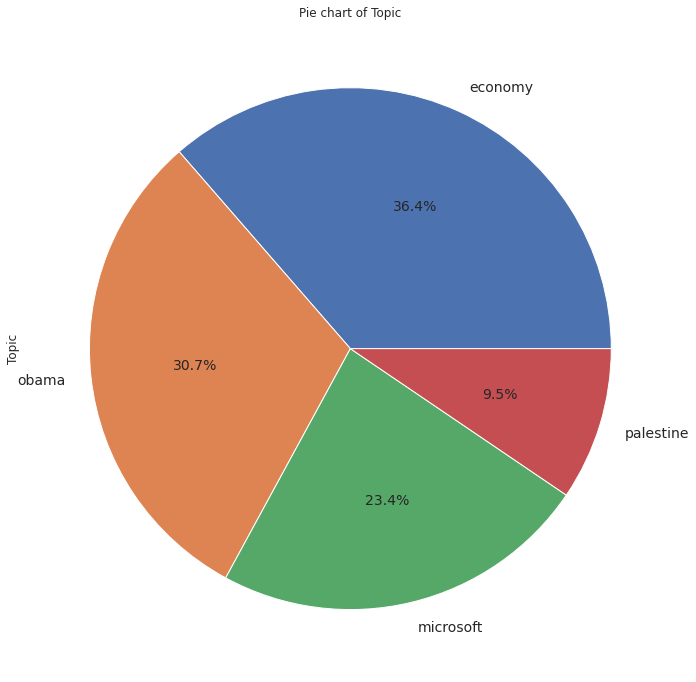

In [10]:
df2=df.copy(deep=True)
pie1=pd.DataFrame(df2['Topic'].value_counts())
pie1.reset_index(inplace=True)
pie1.plot(kind='pie', title='Pie chart of Topic',y = 'Topic', 
          autopct='%1.1f%%', shadow=False, labels=pie1['index'], legend = False, fontsize=14, figsize=(12,12))

Checking nulls

In [11]:
df.isnull().sum()

IDLink                 0
Title                  0
Headline              15
Source               279
Topic                  0
PublishDate            0
SentimentTitle         0
SentimentHeadline      0
Facebook               0
GooglePlus             0
LinkedIn               0
dtype: int64

In [12]:
df = df[df['Headline'].notna()]

In [13]:
df.shape

(93224, 11)

# Data preparation

## Removing URLs:

In [14]:
example="New competition launched :https://www.kaggle.com/c/nlp-getting-started"

In [15]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

remove_URL(example)

'New competition launched :'

In [16]:
df['Headline']=df['Headline'].apply(lambda x : remove_URL(x))

## Removing HTML tags:

In [17]:
example = """<div>
<h1>Real or Fake</h1>
<p>Kaggle </p>
<a href="https://www.kaggle.com/c/nlp-getting-started">getting started</a>
</div>"""

In [18]:
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)
    
print(remove_html(example))


Real or Fake
Kaggle 
getting started



In [19]:
df['Headline']=df['Headline'].apply(lambda x : remove_html(x))

## Removing Emojis:

In [20]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

remove_emoji("Omg another Earthquake 😔😔")

'Omg another Earthquake '

In [21]:
df['Headline']=df['Headline'].apply(lambda x: remove_emoji(x))

## Removing punctuations:

In [22]:
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

example="I am a #king"
print(remove_punct(example))

I am a king


In [23]:
df['Headline']=df['Headline'].apply(lambda x : remove_punct(x))

## Removing numbers:

In [24]:
df['Headline']=df['Headline'].str.replace('\d+', '')

## Removing multiple spaces:

In [25]:
df['Headline']=df['Headline'].str.replace('   ', ' ')
df['Headline']=df['Headline'].str.replace('     ', ' ')
df['Headline']=df['Headline'].str.replace('\xa0 \xa0 \xa0', ' ')
df['Headline']=df['Headline'].str.replace('  ', ' ')
df['Headline']=df['Headline'].str.replace('—', ' ')
df['Headline']=df['Headline'].str.replace('–', ' ')

# Model using BERT
Use Huggingface implementation of BERT. Install the transformers library from their site.

In [26]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 12.9 MB/s 
     |████████████████████████████████| 6.6 MB 44.2 MB/s 
     |████████████████████████████████| 120 kB 57.8 MB/s 


In [27]:
# Load Huggingface transformers
from transformers import TFBertModel,  BertConfig, BertTokenizerFast

# load other
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical
import pandas as pd
from sklearn.model_selection import train_test_split

### Creating training/testing datasets

Converting target column to numeric

In [28]:
# Select required columns
data = df[['Headline', 'Topic']]

# Temporary copy target to a new column
data['Topic_label'] = pd.Categorical(data['Topic'])

# Transform your output to numeric
data['Topic'] = data['Topic_label'].cat.codes

Creating sets

In [29]:
data_train, data_test = train_test_split(data, test_size = 0.1)

### Setup BERT

We load the tokenizer and the bert-base-uncased model.

In [30]:
#######################################
### --------- Setup BERT ---------- ###

# Name of the BERT model to use
model_name = 'bert-base-uncased'

# Max length of tokens
max_length = 45

# Load transformers config and set output_hidden_states to False
config = BertConfig.from_pretrained(model_name)
config.output_hidden_states = False

# Load BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained(pretrained_model_name_or_path = model_name, config = config)

# Load the BERT model
transformer_model = TFBertModel.from_pretrained(model_name, config = config)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


### Model building

In [31]:
bert = transformer_model.layers[0]

# Build your model input
input_ids = Input(shape=(max_length,), name='input_ids', dtype='int32')
inputs = {'input_ids': input_ids}
bert_model = bert(inputs)[1]

dropout = Dropout(config.hidden_dropout_prob, name='pooled_output')
pooled_output = dropout(bert_model, training=False)

# Then build your model output
topics = Dense(units=len(data_train.Topic_label.value_counts()), kernel_initializer=TruncatedNormal(stddev=config.initializer_range), name='topic')(pooled_output)
outputs = {'topic': topics}

# And combine it all in a model object
model = Model(inputs=inputs, outputs=outputs, name='BERT_MultiLabel_MultiClass')

In [32]:
model.summary()

Model: "BERT_MultiLabel_MultiClass"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_ids (InputLayer)      [(None, 45)]              0         
                                                                 
 bert (TFBertMainLayer)      TFBaseModelOutputWithPoo  109482240 
                             lingAndCrossAttentions(l            
                             ast_hidden_state=(None,             
                             45, 768),                           
                              pooler_output=(None, 76            
                             8),                                 
                              past_key_values=None, h            
                             idden_states=None, atten            
                             tions=None, cross_attent            
                             ions=None)                          
                                        

### Model training

Set the optimizer, loss function, accuracy metric. Compile and train.

In [33]:
# Set an optimizer
optimizer = Adam(learning_rate=5e-05,epsilon=1e-08,decay=0.01,clipnorm=1.0)

# Set loss and metrics
loss = {'topic': CategoricalCrossentropy(from_logits = True)}

# Compile the model
model.compile(optimizer = optimizer, loss = loss, metrics = ['accuracy'])

# Ready output data for the model
y_topic = to_categorical(data_train['Topic'])

# Tokenize the input (takes some time)
x = tokenizer(
    text=data_train['Headline'].to_list(),
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

# Fit the model
history = model.fit(
    x={'input_ids': x['input_ids']},
    y={'topic': y_topic},
    validation_split=0.1,
    batch_size=64,
    epochs=2,
    verbose=1)

Epoch 1/2
1180/1180 [==============================] - 720s 590ms/step - loss: 0.0938 - accuracy: 0.9696 - val_loss: 0.0587 - val_accuracy: 0.9796
Epoch 2/2
1180/1180 [==============================] - 695s 589ms/step - loss: 0.0476 - accuracy: 0.9844 - val_loss: 0.0561 - val_accuracy: 0.9808


In [34]:
def plot_metrics(record):
  epoch_range = range(1, len(record.history['accuracy'])+1)
  plt.plot(epoch_range, record.history['accuracy'])
  plt.plot(epoch_range, record.history['val_accuracy'])
  plt.title('Classification Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='lower right')
  plt.show()

  # Plot training & validation loss values
  plt.plot(epoch_range, record.history['loss'])
  plt.plot(epoch_range, record.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='lower right')
  plt.show()

As we ran for only 2 epochs the plot doesn't look too appealing, but makes sense.

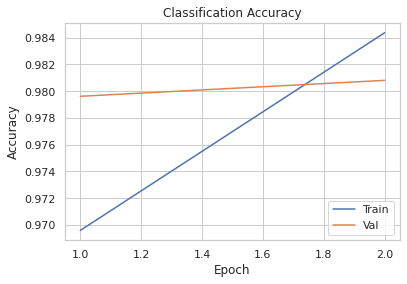

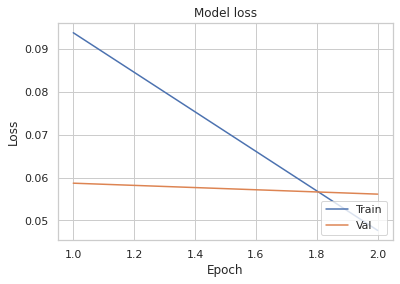

In [35]:
plot_metrics(history)

### Model Evaluation

In [36]:
# Ready test data
test_y_topic = to_categorical(data_test['Topic'])

test_x = tokenizer(
    text=data_test['Headline'].to_list(),
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = False,
    verbose = True)

# Run evaluation
model_eval = model.evaluate(
    x={'input_ids': test_x['input_ids']},
    y={'product': test_y_topic}
)

292/292 [==============================] - 34s 107ms/step - loss: 0.0506 - accuracy: 0.9833


### Inference

In [37]:
label_predicted = model.predict(
    x={'input_ids': test_x['input_ids']},
)

The output is a matrix of predictions where the highest value in each row will specify the predicted class. 

In [38]:
label_predicted['topic']

array([[-1.2324817, -2.343988 ,  5.3185344, -2.3249164],
       [ 5.453986 , -2.0313659, -2.099105 , -2.4620032],
       [ 5.4492564, -1.8726773, -2.1196856, -2.5743213],
       ...,
       [ 5.2660747, -2.6169438, -1.1284214, -2.6652308],
       [-2.1430655,  6.1733704, -1.9394034, -1.6482064],
       [-1.9745528,  6.265739 , -2.1019242, -1.7415943]], dtype=float32)

The test_y_topic is a similar array of predictions, where the value of 1 in a row indicates the selected class.

In [39]:
test_y_topic

array([[0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.]], dtype=float32)

In [40]:
label_pred_max=[np.argmax(i) for i in label_predicted['topic']]

In [41]:
label_actual_max=[np.argmax(i) for i in test_y_topic]

### Classification report

In [42]:
from sklearn.metrics import classification_report

report = classification_report(label_pred_max, label_actual_max)

print(report)

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      3355
           1       0.99      0.99      0.99      2223
           2       0.98      0.98      0.98      2848
           3       0.97      0.98      0.98       897

    accuracy                           0.98      9323
   macro avg       0.98      0.98      0.98      9323
weighted avg       0.98      0.98      0.98      9323



### Confusion matrix

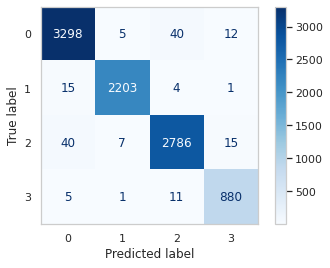

In [43]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(label_pred_max, label_actual_max), display_labels=np.unique(label_actual_max))
disp.plot(cmap='Blues') 
plt.grid(False)

# Model using Embeddings

We will use bag-of-words and pre-trained word embeddings in this part. 

In [44]:
from collections import defaultdict,Counter

### Removing numbers

In [45]:
df['Headline']=df['Headline'].str.replace('\d+', '')

### Removing stopwords

In [46]:
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [47]:
from nltk.corpus import stopwords

In [48]:
stop_words = set(stopwords.words("english"))

Text(0.5, 1.0, '10 most common words in Economy Topic')

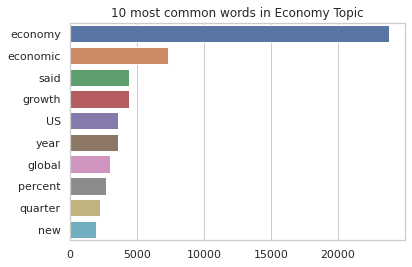

In [49]:
word_count = Counter(" ".join(df[df['Topic']=='economy']['Headline']).split()).most_common(100)
x=[]
y=[]
for word,count in word_count:
    if (word.casefold() not in stop_words) :
        x.append(word)
        y.append(count)

sns.barplot(x=y[:10],y=x[:10])
plt.title('10 most common words in Economy Topic')

Text(0.5, 1.0, '10 most common words in Obama Topic')

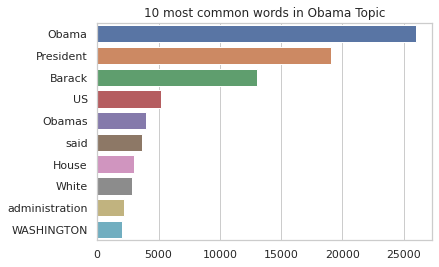

In [50]:
word_count = Counter(" ".join(df[df['Topic']=='obama']['Headline']).split()).most_common(100)
x=[]
y=[]
for word,count in word_count:
    if (word.casefold() not in stop_words) :
        x.append(word)
        y.append(count)

sns.barplot(x=y[:10],y=x[:10])
plt.title('10 most common words in Obama Topic')

Text(0.5, 1.0, '10 most common words in Microsoft Topic')

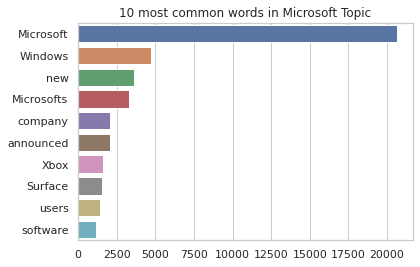

In [51]:
word_count = Counter(" ".join(df[df['Topic']=='microsoft']['Headline']).split()).most_common(100)
x=[]
y=[]
for word,count in word_count:
    if (word.casefold() not in stop_words) :
        x.append(word)
        y.append(count)

sns.barplot(x=y[:10],y=x[:10])
plt.title('10 most common words in Microsoft Topic')

Text(0.5, 1.0, '10 most common words in Palestine Topic')

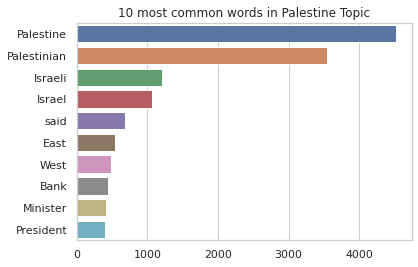

In [52]:
word_count = Counter(" ".join(df[df['Topic']=='palestine']['Headline']).split()).most_common(100)
x=[]
y=[]
for word,count in word_count:
    if (word.casefold() not in stop_words) :
        x.append(word)
        y.append(count)

sns.barplot(x=y[:10],y=x[:10])
plt.title('10 most common words in Palestine Topic')

### N-gram analysis function

In [53]:
# Define ngram generator function
def generate_ngrams(text, n_gram):
    token = [token for token in text.lower().split(' ') if token != '' if token not in stop_words]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

Number of n-grams to generate will be set by variable 'N':

In [54]:
N=10

### Bi-grams:

In [55]:
# Bigrams
economy_bigrams = defaultdict(int)
obama_bigrams = defaultdict(int)
microsoft_bigrams = defaultdict(int)
palestine_bigrams = defaultdict(int)

for instance in df[df['Topic']=='economy']['Headline']:
    for word in generate_ngrams(instance, n_gram=2):
        economy_bigrams[word] += 1     

for instance in df[df['Topic']=='palestine']['Headline']:
    for word in generate_ngrams(instance, n_gram=2):
        palestine_bigrams[word] += 1

for instance in df[df['Topic']=='obama']['Headline']:
    for word in generate_ngrams(instance, n_gram=2):
        obama_bigrams[word] += 1 

for instance in df[df['Topic']=='microsoft']['Headline']:
    for word in generate_ngrams(instance, n_gram=2):
        microsoft_bigrams[word] += 1    

df_palestine_bigrams = pd.DataFrame(sorted(palestine_bigrams.items(), key=lambda x: x[1])[::-1])
df_obama_bigrams = pd.DataFrame(sorted(obama_bigrams.items(), key=lambda x: x[1])[::-1])
df_economy_bigrams = pd.DataFrame(sorted(economy_bigrams.items(), key=lambda x: x[1])[::-1])
df_microsoft_bigrams = pd.DataFrame(sorted(microsoft_bigrams.items(), key=lambda x: x[1])[::-1])

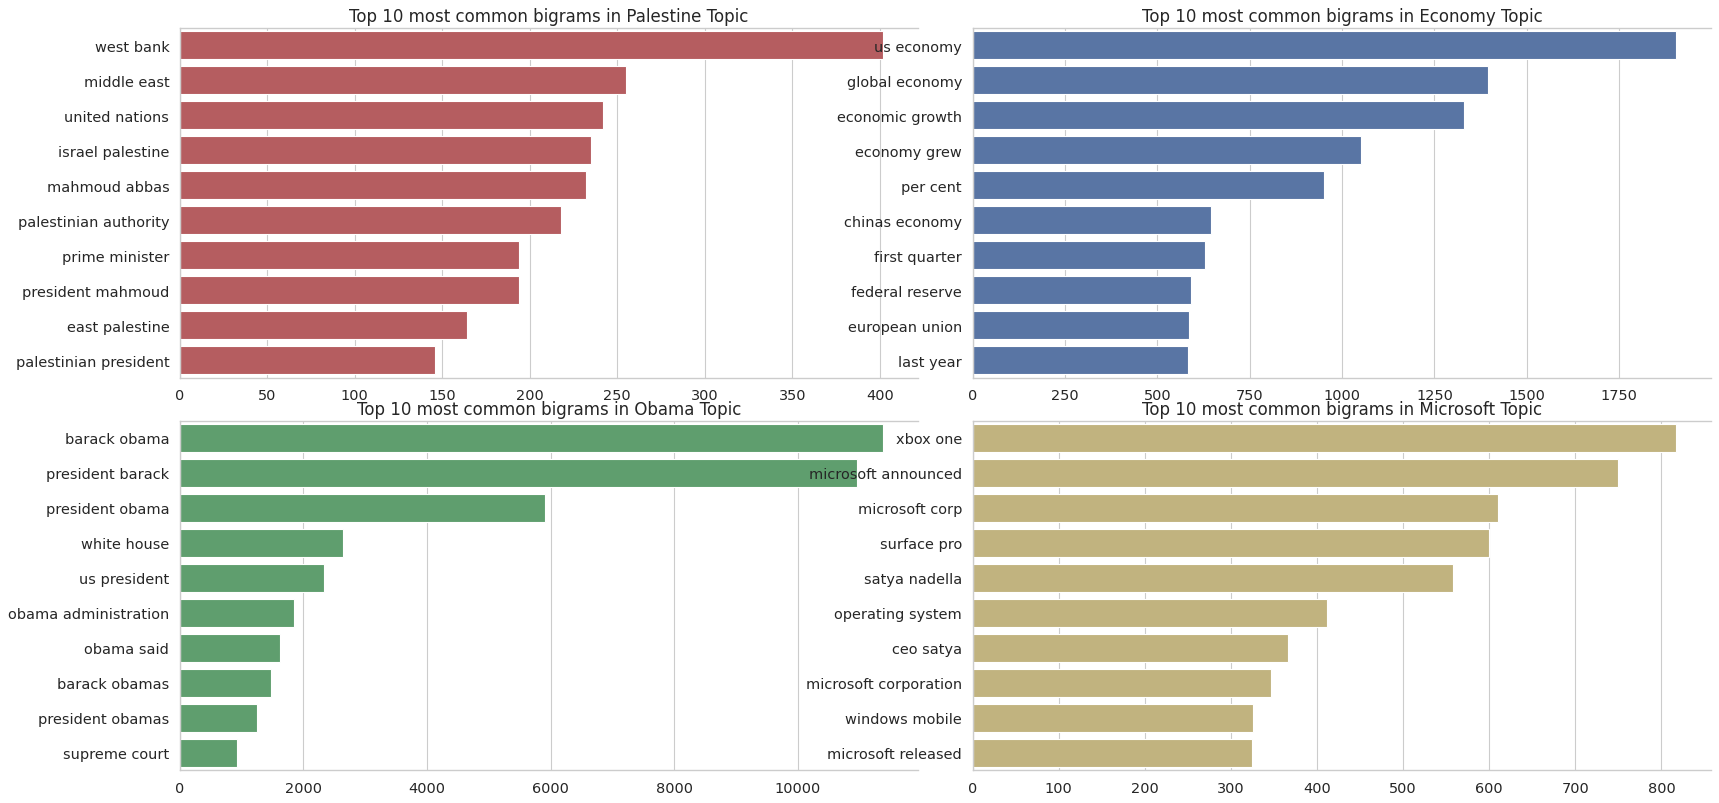

<Figure size 432x288 with 0 Axes>

In [56]:
fig, axes = plt.subplots(2, 2, figsize=(20, 10), dpi=80)
plt.tight_layout()

sns.barplot(y=df_palestine_bigrams[0].values[:N], x=df_palestine_bigrams[1].values[:N], ax=axes[0,0], color='r')
axes[0,0].spines['right'].set_visible(False)
axes[0,0].tick_params(axis='x', labelsize=13)
axes[0,0].tick_params(axis='y', labelsize=13)

sns.barplot(y=df_economy_bigrams[0].values[:N], x=df_economy_bigrams[1].values[:N], ax=axes[0,1], color='b')
axes[0,1].spines['right'].set_visible(False)
axes[0,1].tick_params(axis='x', labelsize=13)
axes[0,1].tick_params(axis='y', labelsize=13)

sns.barplot(y=df_obama_bigrams[0].values[:N], x=df_obama_bigrams[1].values[:N], ax=axes[1,0], color='g')
axes[1,0].spines['right'].set_visible(False)
axes[1,0].tick_params(axis='x', labelsize=13)
axes[1,0].tick_params(axis='y', labelsize=13)

sns.barplot(y=df_microsoft_bigrams[0].values[:N], x=df_microsoft_bigrams[1].values[:N], ax=axes[1,1], color='y')
axes[1,1].spines['right'].set_visible(False)
axes[1,1].tick_params(axis='x', labelsize=13)
axes[1,1].tick_params(axis='y', labelsize=13)

axes[0,0].set_title(f'Top {N} most common bigrams in Palestine Topic', fontsize=15)
axes[0,1].set_title(f'Top {N} most common bigrams in Economy Topic', fontsize=15)
axes[1,0].set_title(f'Top {N} most common bigrams in Obama Topic', fontsize=15)
axes[1,1].set_title(f'Top {N} most common bigrams in Microsoft Topic', fontsize=15)

plt.show()
plt.tight_layout()

### Tri-grams:

In [57]:
# Trigrams
economy_trigrams = defaultdict(int)
obama_trigrams = defaultdict(int)
microsoft_trigrams = defaultdict(int)
palestine_trigrams = defaultdict(int)

for instance in df[df['Topic']=='palestine']['Headline']:
    for word in generate_ngrams(instance, n_gram=3):
        palestine_trigrams[word] += 1

for instance in df[df['Topic']=='obama']['Headline']:
    for word in generate_ngrams(instance, n_gram=3):
        obama_trigrams[word] += 1 

for instance in df[df['Topic']=='economy']['Headline']:
    for word in generate_ngrams(instance, n_gram=3):
        economy_trigrams[word] += 1     

for instance in df[df['Topic']=='microsoft']['Headline']:
    for word in generate_ngrams(instance, n_gram=3):
        microsoft_trigrams[word] += 1    

df_palestine_trigrams = pd.DataFrame(sorted(palestine_trigrams.items(), key=lambda x: x[1])[::-1])
df_obama_trigrams = pd.DataFrame(sorted(obama_trigrams.items(), key=lambda x: x[1])[::-1])
df_economy_trigrams = pd.DataFrame(sorted(economy_trigrams.items(), key=lambda x: x[1])[::-1])
df_microsoft_trigrams = pd.DataFrame(sorted(microsoft_trigrams.items(), key=lambda x: x[1])[::-1])

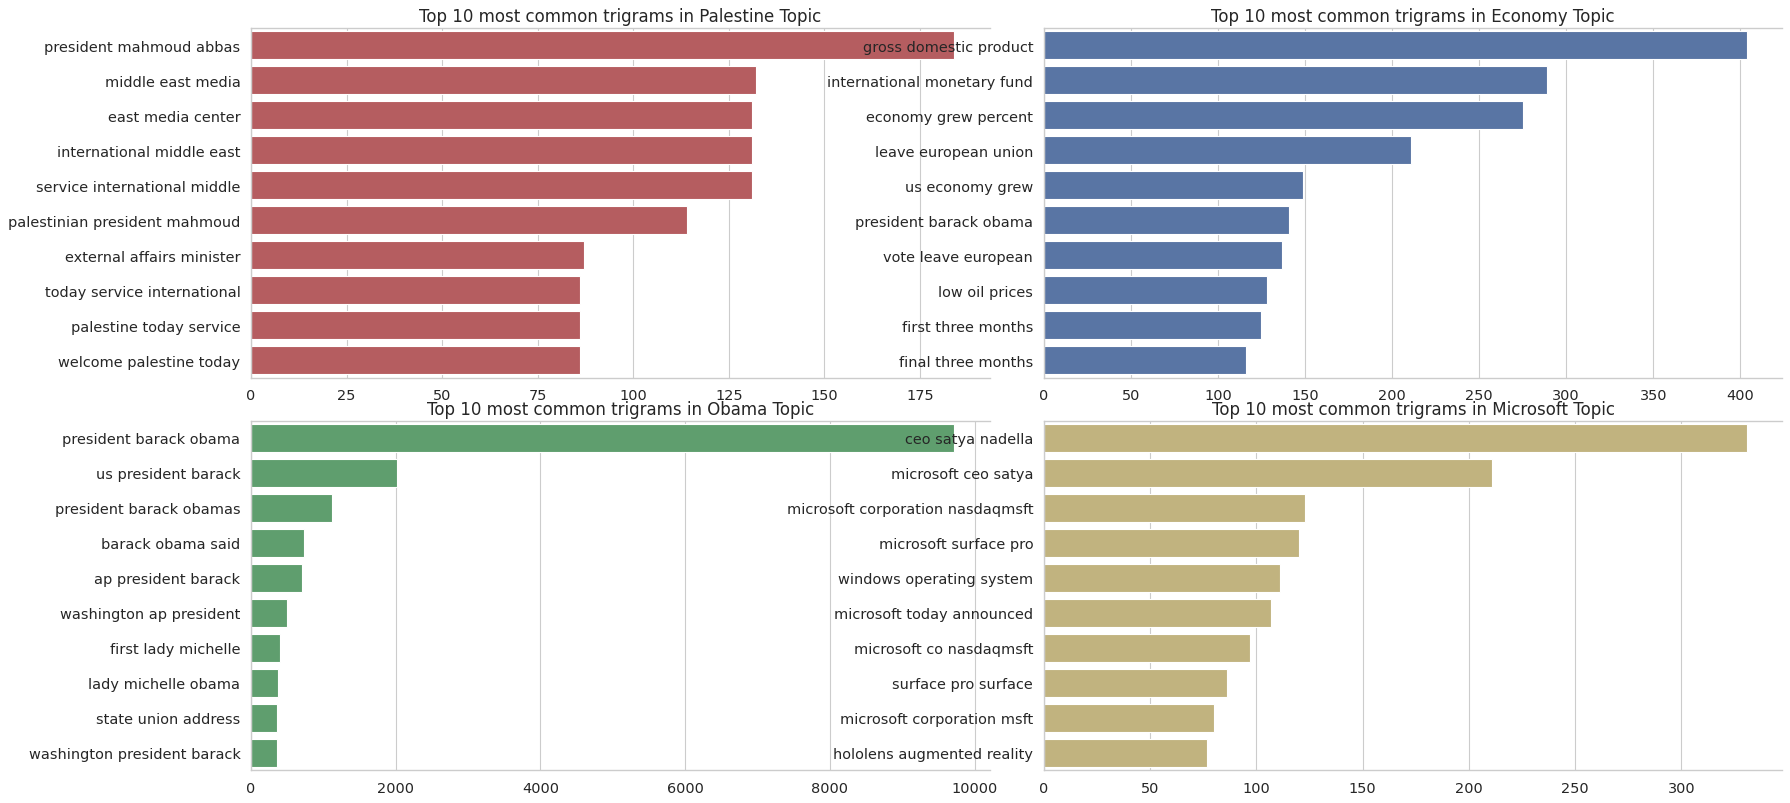

<Figure size 432x288 with 0 Axes>

In [58]:
fig, axes = plt.subplots(2, 2, figsize=(20, 10), dpi=80)
plt.tight_layout()

sns.barplot(y=df_palestine_trigrams[0].values[:N], x=df_palestine_trigrams[1].values[:N], ax=axes[0,0], color='r')
axes[0,0].spines['right'].set_visible(False)
axes[0,0].tick_params(axis='x', labelsize=13)
axes[0,0].tick_params(axis='y', labelsize=13)

sns.barplot(y=df_economy_trigrams[0].values[:N], x=df_economy_trigrams[1].values[:N], ax=axes[0,1], color='b')
axes[0,1].spines['right'].set_visible(False)
axes[0,1].tick_params(axis='x', labelsize=13)
axes[0,1].tick_params(axis='y', labelsize=13)

sns.barplot(y=df_obama_trigrams[0].values[:N], x=df_obama_trigrams[1].values[:N], ax=axes[1,0], color='g')
axes[1,0].spines['right'].set_visible(False)
axes[1,0].tick_params(axis='x', labelsize=13)
axes[1,0].tick_params(axis='y', labelsize=13)

sns.barplot(y=df_microsoft_trigrams[0].values[:N], x=df_microsoft_trigrams[1].values[:N], ax=axes[1,1], color='y')
axes[1,1].spines['right'].set_visible(False)
axes[1,1].tick_params(axis='x', labelsize=13)
axes[1,1].tick_params(axis='y', labelsize=13)

axes[0,0].set_title(f'Top {N} most common trigrams in Palestine Topic', fontsize=15)
axes[0,1].set_title(f'Top {N} most common trigrams in Economy Topic', fontsize=15)
axes[1,0].set_title(f'Top {N} most common trigrams in Obama Topic', fontsize=15)
axes[1,1].set_title(f'Top {N} most common trigrams in Microsoft Topic', fontsize=15)

plt.show()
plt.tight_layout()

### Tokenizing:

In [59]:
df[['Headline','Topic']]

,Headline,Topic
0,Obama Lays Wreath at Arlington National Cemete...,obama
1,Tim Haywood investment director businessunit h...,economy
2,Nouriel Roubini NYU professor and chairman at ...,economy
3,Finlands economy expanded marginally in the th...,economy
4,Tourism and public spending continued to boost...,economy
...,...,...
93234,The June employment report is viewed as a cruc...,economy
93235,In addition establish stimulating economic pol...,economy
93236,The Palestinian government spends nearly milli...,palestine
93237,Palestine Youth Orchestra prepares for first U...,palestine


In [60]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

Remove stopwords and create new column:

In [61]:
df['Headline_without_stopwords'] = df['Headline'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

In [62]:
df[['Headline','Headline_without_stopwords']]

,Headline,Headline_without_stopwords
0,Obama Lays Wreath at Arlington National Cemete...,Obama Lays Wreath Arlington National Cemetery ...
1,Tim Haywood investment director businessunit h...,Tim Haywood investment director businessunit h...
2,Nouriel Roubini NYU professor and chairman at ...,Nouriel Roubini NYU professor chairman Roubini...
3,Finlands economy expanded marginally in the th...,Finlands economy expanded marginally three mon...
4,Tourism and public spending continued to boost...,Tourism public spending continued boost econom...
...,...,...
93234,The June employment report is viewed as a cruc...,The June employment report viewed crucial gaug...
93235,In addition establish stimulating economic pol...,In addition establish stimulating economic pol...
93236,The Palestinian government spends nearly milli...,The Palestinian government spends nearly milli...
93237,Palestine Youth Orchestra prepares for first U...,Palestine Youth Orchestra prepares first UK to...


### Train-test split:

In [63]:
training_portion=0.9

In [64]:
train_size = int(df.shape[0]*training_portion)

train_sentences = df['Headline_without_stopwords'][:train_size]
train_labels = df['Topic'][:train_size]

validation_sentences = df['Headline_without_stopwords'][train_size:]
validation_labels = df['Topic'][train_size:]

Let us tokenize all words in our dataset so as to analyze and get an appropriate vocab_size and max_length: 

In [65]:
#tokenizer0 = Tokenizer()
#tokenizer0.fit_on_texts(train_sentences)
#word_index = tokenizer0.word_index
#len(word_index)

In [66]:
#word_index

Let us set the vocab size to 30.000 so as not to slow down too much the model training later:

In [67]:
vocab_size = 30000
oov_tok = '<OOV>'

In [68]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index

Now, we can compute the length of each instance tokenized of the training set and see its distribution in order to choose maximim length which does not drop significant information at the end of the sequence:

In [69]:
train_sequences = tokenizer.texts_to_sequences(train_sentences)

In [70]:
lengths=[]
for k in range(len(train_sequences)):
  lengths.append(len(train_sequences[k]))

In [71]:
pd.DataFrame(lengths, columns=['Length']).describe()

,Length
count,83901.000000
mean,16.831492
std,7.378212
min,0.000000
25%,13.000000
50%,15.000000
75%,16.000000
max,59.000000


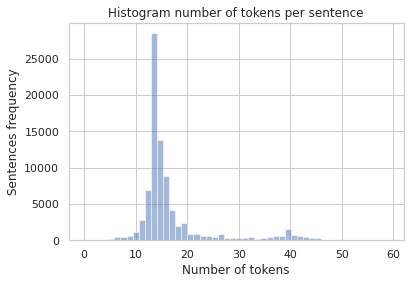

In [72]:
plt.hist(lengths, bins=50, alpha=0.5)
plt.xlabel('Number of tokens')
plt.ylabel('Sentences frequency')
plt.title('Histogram number of tokens per sentence')
plt.show()

Let us set the such argument to 45, truncation type 'post' and padding type 'post' as follows:

In [73]:
max_length = 45
trunc_type = 'post'
padding_type = 'post'

In [74]:
train_padded = pad_sequences(train_sequences,maxlen=max_length,padding=padding_type,truncating=trunc_type)

In [75]:
validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sequences,padding=padding_type,maxlen=max_length,truncating=trunc_type)

In [76]:
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(train_labels)

training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(validation_labels))

In [77]:
np.unique(validation_label_seq)

array([1, 2, 3, 4])

## Modeling:

The following models will be built

- Using own embedding.
- Using Glove-100dim (3 configurations)

## Model0 - own embedding

#### Defining Model

In [78]:
from tensorflow.keras.optimizers import Adam

embedding_dim = 32
model = tf.keras.Sequential([
              tf.keras.layers.Embedding(vocab_size,embedding_dim,input_length=max_length),
              tf.keras.layers.GlobalAveragePooling1D(),
              tf.keras.layers.Dense(24,activation='relu'),
              tf.keras.layers.Dense(5,activation='softmax')
])
opt=Adam(learning_rate=5e-3)
model.compile(loss='sparse_categorical_crossentropy',optimizer=opt,metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 45, 32)            960000    
                                                                 
 global_average_pooling1d (G  (None, 32)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 24)                792       
                                                                 
 dense_1 (Dense)             (None, 5)                 125       
                                                                 
Total params: 960,917
Trainable params: 960,917
Non-trainable params: 0
_________________________________________________________________


### Model training

In [79]:
num_epochs = 10
history = model.fit(train_padded,training_label_seq,epochs=num_epochs,validation_data=(validation_padded,validation_label_seq),verbose=1)

Epoch 1/10
2622/2622 [==============================] - 10s 4ms/step - loss: 0.1350 - accuracy: 0.9547 - val_loss: 0.0791 - val_accuracy: 0.9716
Epoch 2/10
2622/2622 [==============================] - 10s 4ms/step - loss: 0.0355 - accuracy: 0.9887 - val_loss: 0.0925 - val_accuracy: 0.9696
Epoch 3/10
2622/2622 [==============================] - 9s 4ms/step - loss: 0.0193 - accuracy: 0.9940 - val_loss: 0.1212 - val_accuracy: 0.9675
Epoch 4/10
2622/2622 [==============================] - 10s 4ms/step - loss: 0.0118 - accuracy: 0.9964 - val_loss: 0.1753 - val_accuracy: 0.9631
Epoch 5/10
2622/2622 [==============================] - 9s 4ms/step - loss: 0.0075 - accuracy: 0.9974 - val_loss: 0.1843 - val_accuracy: 0.9655
Epoch 6/10
2622/2622 [==============================] - 10s 4ms/step - loss: 0.0055 - accuracy: 0.9980 - val_loss: 0.2157 - val_accuracy: 0.9642
Epoch 7/10
2622/2622 [==============================] - 9s 4ms/step - loss: 0.0051 - accuracy: 0.9980 - val_loss: 0.2181 - val_accur

### Error metrics

In [80]:
def plot_metrics(history):
  acc=history.history['accuracy']
  val_acc=history.history['val_accuracy']
  loss=history.history['loss']
  val_loss=history.history['val_loss']

  epochs=range(len(acc)) # Get number of epochs

  #------------------------------------------------
  # Plot training and validation accuracy per epoch
  #------------------------------------------------
  plt.plot(epochs, acc, 'r')
  plt.plot(epochs, val_acc, 'b')
  plt.title('Training and validation accuracy')
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend(["Accuracy", "Validation Accuracy"])

  plt.figure()

  #------------------------------------------------
  # Plot training and validation loss per epoch
  #------------------------------------------------
  plt.plot(epochs, loss, 'r')
  plt.plot(epochs, val_loss, 'b')
  plt.title('Training and validation loss')
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend(["Loss", "Validation Loss"])

  plt.figure()

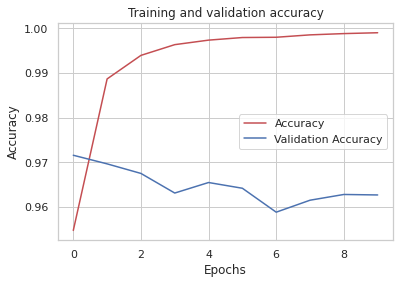

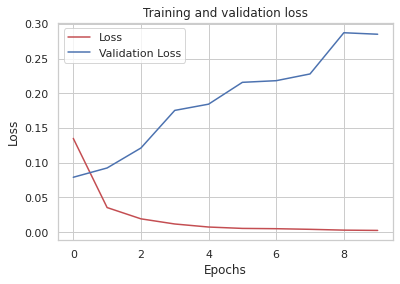

<Figure size 432x288 with 0 Axes>

In [81]:
plot_metrics(history)

### Prediction on validation set

In [82]:
topic_pred=model.predict(validation_padded)
topic_pred

array([[1.0994016e-22, 6.4906402e-10, 9.9999738e-01, 5.8929736e-08,
        2.6786336e-06],
       [1.8659145e-25, 1.1257397e-08, 1.0000000e+00, 6.8694733e-12,
        2.5330653e-11],
       [1.0239385e-17, 9.9998724e-01, 1.1594053e-05, 8.6873007e-07,
        2.1185733e-07],
       ...,
       [5.9715005e-31, 1.0051033e-12, 8.4405830e-14, 5.3413019e-13,
        1.0000000e+00],
       [0.0000000e+00, 1.9688129e-27, 3.1203164e-25, 5.1417042e-26,
        1.0000000e+00],
       [6.0438013e-32, 1.4630562e-15, 1.5855538e-15, 1.0000000e+00,
        4.7842978e-09]], dtype=float32)

As we know the output corresponds to arrays of 5 values corresponding to probability of instances belonging to each class, from these we have to obtain the maximum of them (argmax) and we will get the class predicted:

In [83]:
class_pred_val = [np.argmax(i) for i in topic_pred]
print(class_pred_val[:5])

[2, 2, 1, 1, 2]


Now, we will print the first 5 actual classes for the validation set:

In [84]:
validation_label_seq[:5]

array([[1],
       [2],
       [1],
       [1],
       [2]])

In [85]:
validation_sentences[:5]

83913    Donald Trump supports opening libel laws defen...
83914    It took President Obama finally gotten rid Bla...
83915    At center underground economy sits loose netwo...
83916    Ohio ranked No recent study WalletHub nations ...
83917    President Barack Obama briefed Sunday morning ...
Name: Headline_without_stopwords, dtype: object

In [86]:
validation_labels[:5]

83913    economy
83914      obama
83915    economy
83916    economy
83917      obama
Name: Topic, dtype: object

### Classification report

In [87]:
from sklearn.metrics import classification_report

print(classification_report(class_pred_val,validation_label_seq))

              precision    recall  f1-score   support

           1       0.96      0.96      0.96      3351
           2       0.97      0.95      0.96      2936
           3       0.98      0.98      0.98      2265
           4       0.91      0.94      0.93       771

    accuracy                           0.96      9323
   macro avg       0.95      0.96      0.96      9323
weighted avg       0.96      0.96      0.96      9323



### Confusion matrix

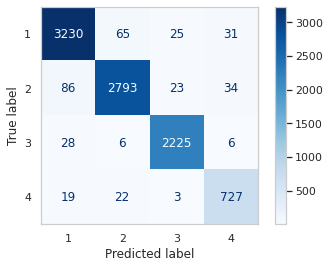

In [88]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(class_pred_val,validation_label_seq), display_labels=np.unique(validation_label_seq))
disp.plot(cmap='Blues') 
plt.grid(False)

In [89]:
label_tokenizer.word_index

{'economy': 1, 'obama': 2, 'microsoft': 3, 'palestine': 4}

## Model 1 - Glove

In [90]:
tokenizer_glove = Tokenizer()
tokenizer_glove.fit_on_texts(train_sentences)
word_index_glove = tokenizer_glove.word_index
len(word_index_glove)

57514

## Tokenizing entire corpus

In [91]:
train_glove_sequences=tokenizer_glove.texts_to_sequences(train_sentences)
train_glove_padded = pad_sequences(train_glove_sequences,maxlen=max_length,
                                   padding=padding_type,truncating=trunc_type)

train_glove_padded.shape

(83901, 45)

In [92]:
val_glove_sequences=tokenizer_glove.texts_to_sequences(validation_sentences)
val_glove_padded = pad_sequences(val_glove_sequences,maxlen=max_length,
                                 padding=padding_type,truncating=trunc_type)

val_glove_padded.shape

(9323, 45)

In [93]:
vocab_size_glove=len(word_index_glove)

Now, as we said we will download the weights of Glove 100 dimensional version  from Stanford:

In [94]:
# glove.6B.100d.txt
!wget "https://nlp.stanford.edu/data/glove.6B.zip" -O "glove.6B.zip" 

--2022-09-12 08:26:08--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-09-12 08:26:09--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.01MB/s    in 2m 40s  

2022-09-12 08:28:50 (5.13 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [95]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [96]:
embeddings_index = {};
#with open('./glove.6B.100d.txt') as f:
with open('/content/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

Finally, create the weight matrix for the first embedding layer of our matrix having dimensions of our vocabulary x 100.

In [97]:
embeddings_matrix = np.zeros((vocab_size_glove+1, 100));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

In [98]:
print(len(embeddings_matrix))

57515


We will try out three different architectures.

## Model 1 - Glove with global averagage pooling

The same configuration as the previous architecutre to see the effect of glove embeddings.

In [99]:
embedding_dim_glove=100
model_glove = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size_glove+1, embedding_dim_glove, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24,activation='relu'),
    tf.keras.layers.Dense(5,activation='softmax')
])
opt=Adam(learning_rate=5e-3)
model_glove.compile(loss='sparse_categorical_crossentropy',optimizer=opt,metrics=['accuracy'])
model_glove.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 45, 100)           5751500   
                                                                 
 global_average_pooling1d_1   (None, 100)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_2 (Dense)             (None, 24)                2424      
                                                                 
 dense_3 (Dense)             (None, 5)                 125       
                                                                 
Total params: 5,754,049
Trainable params: 2,549
Non-trainable params: 5,751,500
_________________________________________________________________


Note the number of trainable parameters is just 2,549. Compare this with Model 0, which has about 960K+ trainable parameters. 

In [100]:
num_epochs = 10
history_glove = model_glove.fit(train_glove_padded,training_label_seq,epochs=num_epochs,
                    validation_data=(val_glove_padded,validation_label_seq),verbose=1)

Epoch 1/10
2622/2622 [==============================] - 7s 3ms/step - loss: 0.7814 - accuracy: 0.6975 - val_loss: 0.6928 - val_accuracy: 0.7369
Epoch 2/10
2622/2622 [==============================] - 7s 3ms/step - loss: 0.7069 - accuracy: 0.7302 - val_loss: 0.6679 - val_accuracy: 0.7475
Epoch 3/10
2622/2622 [==============================] - 7s 2ms/step - loss: 0.6836 - accuracy: 0.7376 - val_loss: 0.6749 - val_accuracy: 0.7403
Epoch 4/10
2622/2622 [==============================] - 6s 2ms/step - loss: 0.6603 - accuracy: 0.7481 - val_loss: 0.6301 - val_accuracy: 0.7598
Epoch 5/10
2622/2622 [==============================] - 7s 2ms/step - loss: 0.6431 - accuracy: 0.7550 - val_loss: 0.6190 - val_accuracy: 0.7643
Epoch 6/10
2622/2622 [==============================] - 7s 2ms/step - loss: 0.6300 - accuracy: 0.7614 - val_loss: 0.6344 - val_accuracy: 0.7578
Epoch 7/10
2622/2622 [==============================] - 7s 3ms/step - loss: 0.6210 - accuracy: 0.7645 - val_loss: 0.6252 - val_accuracy:

The accuracy in train and validation sets were definitely low compared to the earlier our own model. We will change the architecture to see if it improves.

#### Pre-trained model 2:

This model will contain layers we have not used yet, SpatialDropout1D which is the equivalent of dropout in dense layers, but applied to 1D-sequences, then a LSTM with 45 units (equal to the sentence length) and finally a Dense softmax layer:

In [101]:
from tensorflow.keras.optimizers import Adam

model_glove2=Sequential()
model_glove2.add(Embedding(vocab_size_glove+1,100,weights=[embeddings_matrix],input_length=max_length,trainable=False))
model_glove2.add(SpatialDropout1D(0.2))
model_glove2.add(LSTM(45, dropout=0.2, recurrent_dropout=0.2))
model_glove2.add(Dense(5, activation='softmax'))

opt=Adam(learning_rate=5e-3)
model_glove2.compile(loss='sparse_categorical_crossentropy',optimizer=opt,metrics=['accuracy'])
model_glove2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 45, 100)           5751500   
                                                                 
 spatial_dropout1d (SpatialD  (None, 45, 100)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 45)                26280     
                                                                 
 dense_4 (Dense)             (None, 5)                 230       
                                                                 
Total params: 5,778,010
Trainable params: 26,510
Non-trainable params: 5,751,500
_________________________________________________________________


In [102]:
num_epochs = 5
history_glove2 = model_glove2.fit(train_glove_padded,training_label_seq,epochs=num_epochs,
                      validation_data=(val_glove_padded,validation_label_seq),verbose=1,
                      batch_size=32)

Epoch 1/5
2622/2622 [==============================] - 462s 175ms/step - loss: 0.5678 - accuracy: 0.7602 - val_loss: 0.2384 - val_accuracy: 0.9099
Epoch 2/5
2622/2622 [==============================] - 455s 173ms/step - loss: 0.2608 - accuracy: 0.9024 - val_loss: 0.1991 - val_accuracy: 0.9238
Epoch 3/5
2622/2622 [==============================] - 450s 172ms/step - loss: 0.2286 - accuracy: 0.9146 - val_loss: 0.1866 - val_accuracy: 0.9270
Epoch 4/5
2622/2622 [==============================] - 454s 173ms/step - loss: 0.2156 - accuracy: 0.9183 - val_loss: 0.1777 - val_accuracy: 0.9276
Epoch 5/5
2622/2622 [==============================] - 452s 172ms/step - loss: 0.2053 - accuracy: 0.9211 - val_loss: 0.1744 - val_accuracy: 0.9310


The use of LSTM resulted in faster training and achieved a good accuracy in just 5 epochs. 

#### Pre-trained model 3:

We will go back to the first architecture and change the GlobalAveragePooling1D with LSTM of 45 units followed by 2 Dense layers, let us see the performance:

In [103]:
model_glove3=Sequential()
model_glove3.add(Embedding(vocab_size_glove+1,100,weights=[embeddings_matrix],input_length=max_length,trainable=False))
model_glove3.add(LSTM(45, dropout=0.2, recurrent_dropout=0.2))
model_glove3.add(Dense(24,activation='relu'))
model_glove3.add(Dense(5, activation='softmax'))

opt=Adam(learning_rate=5e-3)
model_glove3.compile(loss='sparse_categorical_crossentropy',optimizer=opt,metrics=['accuracy'])
model_glove3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 45, 100)           5751500   
                                                                 
 lstm_1 (LSTM)               (None, 45)                26280     
                                                                 
 dense_5 (Dense)             (None, 24)                1104      
                                                                 
 dense_6 (Dense)             (None, 5)                 125       
                                                                 
Total params: 5,779,009
Trainable params: 27,509
Non-trainable params: 5,751,500
_________________________________________________________________


In [104]:
num_epochs = 5
history_glove3 = model_glove3.fit(train_glove_padded,training_label_seq,epochs=num_epochs,
                      validation_data=(val_glove_padded,validation_label_seq),verbose=1,
                      batch_size=32)

Epoch 1/5
2622/2622 [==============================] - 464s 176ms/step - loss: 0.7968 - accuracy: 0.6360 - val_loss: 0.2615 - val_accuracy: 0.8963
Epoch 2/5
2622/2622 [==============================] - 460s 175ms/step - loss: 0.2466 - accuracy: 0.9073 - val_loss: 0.1895 - val_accuracy: 0.9271
Epoch 3/5
2622/2622 [==============================] - 459s 175ms/step - loss: 0.2077 - accuracy: 0.9222 - val_loss: 0.1796 - val_accuracy: 0.9272
Epoch 4/5
2622/2622 [==============================] - 461s 176ms/step - loss: 0.1933 - accuracy: 0.9279 - val_loss: 0.1655 - val_accuracy: 0.9371
Epoch 5/5
2622/2622 [==============================] - 462s 176ms/step - loss: 0.1841 - accuracy: 0.9315 - val_loss: 0.1597 - val_accuracy: 0.9412


This performed better than the earlier one, but could not beat our first model-0. It also took longer time to train. 

Let us display the plots for these metrics, compute the classification report and show the confusion matrix to see in more detail all misclassifications.

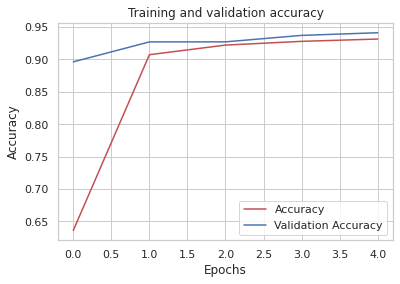

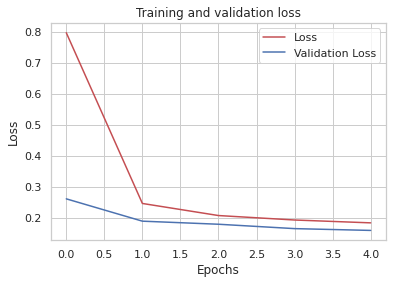

<Figure size 432x288 with 0 Axes>

In [105]:
plot_metrics(history_glove3)

##### Prediction for validation set:

Let us predict the topics for the validation set and print the first 5 so as to compare them and compute the error metrics:

In [106]:
topic_pred_glove=model_glove3.predict(val_glove_padded)
topic_pred_glove

array([[4.0238096e-13, 2.2993200e-01, 7.2290927e-01, 1.9349661e-02,
        2.7809011e-02],
       [7.1943941e-19, 8.9173773e-03, 9.8719227e-01, 6.4501754e-04,
        3.2453120e-03],
       [1.5503563e-15, 9.9929118e-01, 5.2077969e-04, 4.6453228e-05,
        1.4149699e-04],
       ...,
       [7.7546283e-17, 3.4600843e-04, 5.0928968e-05, 1.4260630e-05,
        9.9958879e-01],
       [3.6401212e-18, 2.4160731e-04, 5.0026472e-05, 5.1884141e-05,
        9.9965644e-01],
       [1.6749729e-15, 1.1543745e-04, 1.0819160e-04, 9.9976760e-01,
        8.6539949e-06]], dtype=float32)

As we know the output corresponds to arrays of 5 values corresponding to probability of instances belonging to each class, from these we have to obtain the maximum of them (argmax) and we will get the class predicted:

In [107]:
class_pred_val_glove = [np.argmax(i) for i in topic_pred_glove]
print(class_pred_val_glove[:5])

[2, 2, 1, 1, 2]


Now, we will print the first 5 actual classes for the validation set:

In [108]:
validation_label_seq[:5]

array([[1],
       [2],
       [1],
       [1],
       [2]])

Classification report and confusion matrix:

In [109]:
from sklearn.metrics import classification_report

print(classification_report(class_pred_val_glove,validation_label_seq))

              precision    recall  f1-score   support

           1       0.96      0.91      0.94      3541
           2       0.93      0.95      0.94      2830
           3       0.95      1.00      0.97      2173
           4       0.87      0.89      0.88       779

    accuracy                           0.94      9323
   macro avg       0.93      0.94      0.93      9323
weighted avg       0.94      0.94      0.94      9323



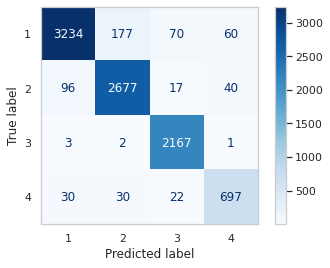

In [110]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(class_pred_val_glove,validation_label_seq), display_labels=np.unique(validation_label_seq))
disp.plot(cmap='Blues') 
plt.grid(False)

In [111]:
label_tokenizer.word_index

{'economy': 1, 'obama': 2, 'microsoft': 3, 'palestine': 4}

Our own embeddings gave better performance compared to the three models developed based on Glove. BERT is probably a better choice amongst all the tested models. 